# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import pimmslearn
import pimmslearn.analyzers
import pimmslearn.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
pimmslearn.plotting.make_large_descriptors(fontsize)


logger = pimmslearn.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "DAE"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = pimmslearn.nb.get_params(args, globals=globals())
args = pimmslearn.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = pimmslearn.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'DAE',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = pimmslearn.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

pimmslearn.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


pimmslearn.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


pimmslearn.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups 
Sample_170  P02671            19.621
Sample_003  Q01995            15.578
Sample_081  P00740;P00740-2   16.808
Sample_167  Q9NPC4            14.140
Sample_175  F5H1U3;Q02790     13.414
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = pimmslearn.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[pimmslearn.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = pimmslearn.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by DAE: runs/alzheimer_study/preds/pred_real_na_DAE.csv


Sample ID   protein groups          
Sample_086  J3KQ18;P30046              15.649
Sample_129  Q96RW7;Q96RW7-2            13.140
Sample_121  O00339;O00339-2;O00339-3   14.753
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 13.288
            A0A075B6Q5                 12.776
            A0A075B6R2                 13.299
            A0A075B6S5                 12.779
            A0A087WSY4                 13.030
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   13.555
            Q9UI40;Q9UI40-2            13.316
            Q9UIW2                     12.828
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   13.034
            Q9UP79                     13.221
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,13.696,15.050,16.842,19.863,15.897,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.581,19.067,...,15.528,15.576,13.900,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,15.722,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,15.108,17.705,17.039,15.418,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,15.202,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,14.689,15.345,17.084,18.708,14.249,19.433,11.362,10.634
Sample_207,15.739,16.877,15.469,16.898,13.345,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,13.288,...,16.012,15.178,12.847,15.050,16.842,19.863,12.588,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,13.955,19.067,16.188,...,15.528,15.576,12.683,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,13.371,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,13.910,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,13.066,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,13.149,15.345,17.084,18.708,14.249,19.433,12.932,12.773
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 335.09it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  3.16it/s]

100%|██████████| 2/2 [00:00<00:00,  3.15it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  6.07it/s]

100%|██████████| 3/3 [00:00<00:00,  3.85it/s]

100%|██████████| 3/3 [00:00<00:00,  4.14it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  4.55it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  3.21it/s]

100%|██████████| 4/4 [00:01<00:00,  2.26it/s]

100%|██████████| 4/4 [00:01<00:00,  2.60it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  3.05it/s]

 60%|██████    | 3/5 [00:01<00:00,  2.26it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.08it/s]

100%|██████████| 5/5 [00:02<00:00,  2.12it/s]

100%|██████████| 5/5 [00:02<00:00,  2.21it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  5.38it/s]

 50%|█████     | 3/6 [00:00<00:00,  4.33it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  3.96it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.41it/s]

100%|██████████| 6/6 [00:01<00:00,  3.21it/s]

100%|██████████| 6/6 [00:01<00:00,  3.58it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  5.11it/s]

 43%|████▎     | 3/7 [00:00<00:01,  3.11it/s]

 57%|█████▋    | 4/7 [00:01<00:01,  2.64it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  2.58it/s]

 86%|████████▌ | 6/7 [00:02<00:00,  2.52it/s]

100%|██████████| 7/7 [00:02<00:00,  2.64it/s]

100%|██████████| 7/7 [00:02<00:00,  2.77it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  5.46it/s]

 38%|███▊      | 3/8 [00:00<00:01,  3.75it/s]

 50%|█████     | 4/8 [00:01<00:01,  3.31it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  3.23it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  3.30it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  3.26it/s]

100%|██████████| 8/8 [00:02<00:00,  3.16it/s]

100%|██████████| 8/8 [00:02<00:00,  3.36it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  5.04it/s]

 33%|███▎      | 3/9 [00:00<00:01,  3.93it/s]

 44%|████▍     | 4/9 [00:01<00:01,  3.60it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  3.54it/s]

 67%|██████▋   | 6/9 [00:02<00:01,  2.41it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.05it/s]

 89%|████████▉ | 8/9 [00:03<00:00,  1.86it/s]

100%|██████████| 9/9 [00:03<00:00,  1.79it/s]

100%|██████████| 9/9 [00:03<00:00,  2.30it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:02,  3.05it/s]

 30%|███       | 3/10 [00:01<00:03,  1.84it/s]

 40%|████      | 4/10 [00:02<00:03,  1.76it/s]

 50%|█████     | 5/10 [00:02<00:02,  1.88it/s]

 60%|██████    | 6/10 [00:02<00:01,  2.08it/s]

 70%|███████   | 7/10 [00:03<00:01,  2.13it/s]

 80%|████████  | 8/10 [00:03<00:00,  2.41it/s]

 90%|█████████ | 9/10 [00:03<00:00,  2.64it/s]

100%|██████████| 10/10 [00:04<00:00,  2.85it/s]

100%|██████████| 10/10 [00:04<00:00,  2.34it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:02,  4.18it/s]

 27%|██▋       | 3/11 [00:00<00:02,  2.98it/s]

 36%|███▋      | 4/11 [00:01<00:02,  3.09it/s]

 45%|████▌     | 5/11 [00:01<00:01,  3.00it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  3.02it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  3.11it/s]

 73%|███████▎  | 8/11 [00:02<00:00,  3.15it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  3.09it/s]

 91%|█████████ | 10/11 [00:03<00:00,  3.04it/s]

100%|██████████| 11/11 [00:03<00:00,  3.01it/s]

100%|██████████| 11/11 [00:03<00:00,  3.09it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  6.17it/s]

 25%|██▌       | 3/12 [00:00<00:02,  4.03it/s]

 33%|███▎      | 4/12 [00:01<00:02,  3.66it/s]

 42%|████▏     | 5/12 [00:01<00:02,  3.48it/s]

 50%|█████     | 6/12 [00:01<00:01,  3.42it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  3.29it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  3.36it/s]

 75%|███████▌  | 9/12 [00:02<00:00,  3.22it/s]

 83%|████████▎ | 10/12 [00:03<00:00,  2.77it/s]

 92%|█████████▏| 11/12 [00:03<00:00,  2.41it/s]

100%|██████████| 12/12 [00:04<00:00,  2.05it/s]

100%|██████████| 12/12 [00:04<00:00,  2.82it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  5.53it/s]

 23%|██▎       | 3/13 [00:00<00:02,  3.87it/s]

 31%|███       | 4/13 [00:01<00:02,  3.38it/s]

 38%|███▊      | 5/13 [00:01<00:02,  3.33it/s]

 46%|████▌     | 6/13 [00:01<00:02,  2.94it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.41it/s]

 62%|██████▏   | 8/13 [00:02<00:02,  2.12it/s]

 69%|██████▉   | 9/13 [00:03<00:02,  1.92it/s]

 77%|███████▋  | 10/13 [00:04<00:01,  1.79it/s]

 85%|████████▍ | 11/13 [00:04<00:01,  1.75it/s]

 92%|█████████▏| 12/13 [00:05<00:00,  1.91it/s]

100%|██████████| 13/13 [00:05<00:00,  2.09it/s]

100%|██████████| 13/13 [00:05<00:00,  2.30it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  5.59it/s]

 21%|██▏       | 3/14 [00:01<00:04,  2.44it/s]

 29%|██▊       | 4/14 [00:01<00:05,  1.79it/s]

 36%|███▌      | 5/14 [00:02<00:05,  1.68it/s]

 43%|████▎     | 6/14 [00:03<00:04,  1.66it/s]

 50%|█████     | 7/14 [00:03<00:04,  1.73it/s]

 57%|█████▋    | 8/14 [00:04<00:03,  1.90it/s]

 64%|██████▍   | 9/14 [00:04<00:02,  1.97it/s]

 71%|███████▏  | 10/14 [00:05<00:01,  2.01it/s]

 79%|███████▊  | 11/14 [00:05<00:01,  2.09it/s]

 86%|████████▌ | 12/14 [00:05<00:00,  2.10it/s]

 93%|█████████▎| 13/14 [00:06<00:00,  2.09it/s]

100%|██████████| 14/14 [00:06<00:00,  2.14it/s]

100%|██████████| 14/14 [00:06<00:00,  2.03it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:04,  3.21it/s]

 20%|██        | 3/15 [00:01<00:05,  2.15it/s]

 27%|██▋       | 4/15 [00:01<00:05,  1.88it/s]

 33%|███▎      | 5/15 [00:02<00:05,  1.80it/s]

 40%|████      | 6/15 [00:02<00:04,  2.08it/s]

 47%|████▋     | 7/15 [00:03<00:03,  2.27it/s]

 53%|█████▎    | 8/15 [00:03<00:03,  2.33it/s]

 60%|██████    | 9/15 [00:04<00:02,  2.27it/s]

 67%|██████▋   | 10/15 [00:04<00:02,  2.24it/s]

 73%|███████▎  | 11/15 [00:05<00:01,  2.24it/s]

 80%|████████  | 12/15 [00:05<00:01,  2.22it/s]

 87%|████████▋ | 13/15 [00:05<00:00,  2.24it/s]

 93%|█████████▎| 14/15 [00:06<00:00,  2.29it/s]

100%|██████████| 15/15 [00:06<00:00,  2.33it/s]

100%|██████████| 15/15 [00:06<00:00,  2.23it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.005 0.003      0.064 0.023          0.825 0.292       0.135   
2             0.005 0.005      0.080 0.035          0.664 0.099       0.535   
3             0.008 0.007      0.088 0.043          0.748 0.084       0.737   
4             0.004 0.002      0.058 0.019          0.763 0.085       0.762   
5             0.006 0.005      0.079 0.033          0.776 0.099       0.768   
6             0.009 0.008      0.098 0.034          0.771 0.107       0.769   
7             0.005 0.003      0.069 0.030          0.767 0.106       0.768   
8             0.008 0.009      0.095 0.046          0.796 0.094       0.786   
9             0.005 0.004      0.077 0.026          0.813 0.083       0.842   
10            0.007 0.007      0.083 0.041          0.812 0.082       0.843   
11            0.010 0.010      0.101 0.046          0.811 0.081       0.841   
12            0.008 0.007      0.096 0.047          0.811 0.087       0.839   
13            0.007 0.006      0.081 0.039          0.806 0.090       0.829   
14            0.005 0.004      0.064 0.024          0.803 0.093       0.821   
15            0.005 0.003      0.069 0.024          0.796 0.089       0.822   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.085   0.224 0.127                  0.560 0.042        0.860   
2          0.114   0.583 0.080                  0.664 0.053        0.737   
3          0.116   0.737 0.079                  0.776 0.064        0.854   
4          0.125   0.756 0.082                  0.793 0.066        0.857   
5          0.101   0.766 0.073                  0.799 0.061        0.878   
6          0.110   0.764 0.081                  0.797 0.067        0.877   
7          0.103   0.761 0.077                  0.795 0.065        0.875   
8          0.091   0.787 0.075                  0.818 0.063        0.896   
9          0.081   0.824 0.064                  0.849 0.056        0.918   
10         0.080   0.825 0.063                  0.849 0.055        0.917   
11         0.082   0.823 0.063                  0.847 0.055        0.916   
12         0.088   0.821 0.066                  0.846 0.057        0.914   
13         0.086   0.813 0.064                  0.839 0.056        0.912   
14         0.091   0.808 0.068                  0.834 0.059        0.911   
15         0.086   0.805 0.064                  0.832 0.056        0.911   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.060                  0.827 0.087        210.000 0.000  
2          0.069                  0.663 0.090        210.000 0.000  
3          0.062                  0.822 0.079        210.000 0.000  
4          0.064                  0.823 0.081        210.000 0.000  
5          0.053                  0.846 0.073        210.000 0.000  
6          0.052                  0.847 0.072        210.000 0.000  
7          0.051                  0.846 0.070        210.000 0.000  
8          0.048                  0.881 0.057        210.000 0.000  
9          0.042                  0.905 0.048        210.000 0.000  
10         0.042                  0.904 0.048        210.000 0.000  
11         0.044                  0.903 0.050        210.000 0.000  
12         0.046                  0.899 0.054        210.000 0.000  
13         0.046                  0.897 0.053        210.000 0.000  
14         0.047                  0.896 0.053        210.000 0.000  
15         0.047                  0.896 0.054 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 456.85it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  5.61it/s]

100%|██████████| 2/2 [00:00<00:00,  5.57it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  4.57it/s]

100%|██████████| 3/3 [00:00<00:00,  3.25it/s]

100%|██████████| 3/3 [00:00<00:00,  3.44it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  4.64it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  3.11it/s]

100%|██████████| 4/4 [00:01<00:00,  2.31it/s]

100%|██████████| 4/4 [00:01<00:00,  2.62it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  4.50it/s]

 60%|██████    | 3/5 [00:00<00:00,  3.37it/s]

 80%|████████  | 4/5 [00:01<00:00,  3.12it/s]

100%|██████████| 5/5 [00:01<00:00,  2.92it/s]

100%|██████████| 5/5 [00:01<00:00,  3.14it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  4.14it/s]

 50%|█████     | 3/6 [00:00<00:00,  3.08it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.66it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  2.24it/s]

100%|██████████| 6/6 [00:02<00:00,  2.21it/s]

100%|██████████| 6/6 [00:02<00:00,  2.46it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:01,  3.78it/s]

 43%|████▎     | 3/7 [00:01<00:01,  2.31it/s]

 57%|█████▋    | 4/7 [00:01<00:01,  2.07it/s]

 71%|███████▏  | 5/7 [00:02<00:01,  1.84it/s]

 86%|████████▌ | 6/7 [00:02<00:00,  1.93it/s]

100%|██████████| 7/7 [00:03<00:00,  2.09it/s]

100%|██████████| 7/7 [00:03<00:00,  2.13it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  5.34it/s]

 38%|███▊      | 3/8 [00:00<00:01,  3.87it/s]

 50%|█████     | 4/8 [00:01<00:01,  3.37it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  3.14it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  2.73it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  2.80it/s]

100%|██████████| 8/8 [00:02<00:00,  2.72it/s]

100%|██████████| 8/8 [00:02<00:00,  3.02it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  5.42it/s]

 33%|███▎      | 3/9 [00:00<00:01,  3.90it/s]

 44%|████▍     | 4/9 [00:01<00:01,  3.30it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  3.14it/s]

 67%|██████▋   | 6/9 [00:01<00:01,  2.60it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.54it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  2.50it/s]

100%|██████████| 9/9 [00:03<00:00,  2.51it/s]

100%|██████████| 9/9 [00:03<00:00,  2.82it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  5.65it/s]

 30%|███       | 3/10 [00:00<00:01,  3.63it/s]

 40%|████      | 4/10 [00:01<00:01,  3.22it/s]

 50%|█████     | 5/10 [00:01<00:01,  2.82it/s]

 60%|██████    | 6/10 [00:02<00:01,  2.64it/s]

 70%|███████   | 7/10 [00:02<00:01,  2.62it/s]

 80%|████████  | 8/10 [00:02<00:00,  2.66it/s]

 90%|█████████ | 9/10 [00:03<00:00,  2.24it/s]

100%|██████████| 10/10 [00:03<00:00,  2.10it/s]

100%|██████████| 10/10 [00:03<00:00,  2.57it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  4.58it/s]

 27%|██▋       | 3/11 [00:00<00:02,  3.12it/s]

 36%|███▋      | 4/11 [00:01<00:02,  2.86it/s]

 45%|████▌     | 5/11 [00:01<00:02,  2.81it/s]

 55%|█████▍    | 6/11 [00:02<00:01,  2.80it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.80it/s]

 73%|███████▎  | 8/11 [00:02<00:01,  2.76it/s]

 82%|████████▏ | 9/11 [00:03<00:00,  2.52it/s]

 91%|█████████ | 10/11 [00:03<00:00,  2.50it/s]

100%|██████████| 11/11 [00:03<00:00,  2.61it/s]

100%|██████████| 11/11 [00:03<00:00,  2.76it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:02,  4.17it/s]

 25%|██▌       | 3/12 [00:01<00:03,  2.73it/s]

 33%|███▎      | 4/12 [00:01<00:02,  2.68it/s]

 42%|████▏     | 5/12 [00:01<00:02,  2.72it/s]

 50%|█████     | 6/12 [00:02<00:02,  2.76it/s]

 58%|█████▊    | 7/12 [00:02<00:01,  2.76it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  2.54it/s]

 75%|███████▌  | 9/12 [00:03<00:01,  2.47it/s]

 83%|████████▎ | 10/12 [00:03<00:00,  2.53it/s]

 92%|█████████▏| 11/12 [00:04<00:00,  2.61it/s]

100%|██████████| 12/12 [00:04<00:00,  2.34it/s]

100%|██████████| 12/12 [00:04<00:00,  2.58it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  4.38it/s]

 23%|██▎       | 3/13 [00:00<00:03,  3.23it/s]

 31%|███       | 4/13 [00:01<00:03,  2.93it/s]

 38%|███▊      | 5/13 [00:01<00:02,  2.70it/s]

 46%|████▌     | 6/13 [00:02<00:02,  2.70it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.45it/s]

 62%|██████▏   | 8/13 [00:02<00:02,  2.50it/s]

 69%|██████▉   | 9/13 [00:03<00:01,  2.49it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.49it/s]

 85%|████████▍ | 11/13 [00:04<00:00,  2.57it/s]

 92%|█████████▏| 12/13 [00:04<00:00,  2.39it/s]

100%|██████████| 13/13 [00:05<00:00,  1.95it/s]

100%|██████████| 13/13 [00:05<00:00,  2.44it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  4.85it/s]

 21%|██▏       | 3/14 [00:00<00:02,  3.69it/s]

 29%|██▊       | 4/14 [00:01<00:03,  3.31it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.16it/s]

 43%|████▎     | 6/14 [00:02<00:03,  2.57it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.58it/s]

 57%|█████▋    | 8/14 [00:02<00:02,  2.53it/s]

 64%|██████▍   | 9/14 [00:03<00:02,  2.29it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.43it/s]

 79%|███████▊  | 11/14 [00:04<00:01,  2.10it/s]

 86%|████████▌ | 12/14 [00:04<00:01,  1.93it/s]

 93%|█████████▎| 13/14 [00:05<00:00,  1.85it/s]

100%|██████████| 14/14 [00:06<00:00,  1.83it/s]

100%|██████████| 14/14 [00:06<00:00,  2.30it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  4.36it/s]

 20%|██        | 3/15 [00:00<00:03,  3.13it/s]

 27%|██▋       | 4/15 [00:01<00:04,  2.62it/s]

 33%|███▎      | 5/15 [00:01<00:03,  2.54it/s]

 40%|████      | 6/15 [00:02<00:03,  2.52it/s]

 47%|████▋     | 7/15 [00:02<00:03,  2.48it/s]

 53%|█████▎    | 8/15 [00:03<00:02,  2.50it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.63it/s]

 67%|██████▋   | 10/15 [00:03<00:02,  2.31it/s]

 73%|███████▎  | 11/15 [00:04<00:01,  2.03it/s]

 80%|████████  | 12/15 [00:05<00:01,  1.76it/s]

 87%|████████▋ | 13/15 [00:05<00:01,  1.82it/s]

 93%|█████████▎| 14/15 [00:06<00:00,  1.96it/s]

100%|██████████| 15/15 [00:06<00:00,  2.07it/s]

100%|██████████| 15/15 [00:06<00:00,  2.26it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.006 0.005      0.081 0.039          0.118 0.288       0.013   
2             0.008 0.006      0.102 0.035          0.622 0.343       0.153   
3             0.005 0.004      0.074 0.028          0.676 0.100       0.551   
4             0.007 0.006      0.094 0.037          0.676 0.101       0.564   
5             0.006 0.005      0.103 0.034          0.657 0.097       0.603   
6             0.006 0.005      0.071 0.028          0.750 0.088       0.710   
7             0.006 0.005      0.087 0.039          0.763 0.089       0.718   
8             0.006 0.005      0.070 0.030          0.768 0.085       0.803   
9             0.005 0.004      0.073 0.032          0.764 0.089       0.800   
10            0.006 0.005      0.067 0.024          0.760 0.091       0.798   
11            0.006 0.005      0.069 0.025          0.788 0.087       0.806   
12            0.007 0.005      0.070 0.031          0.787 0.084       0.803   
13            0.006 0.004      0.070 0.025          0.777 0.081       0.805   
14            0.005 0.003      0.061 0.019          0.789 0.083       0.793   
15            0.006 0.005      0.076 0.031          0.780 0.086       0.805   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.034   0.023 0.058                  0.502 0.015        0.865   
2          0.113   0.229 0.152                  0.548 0.049        0.747   
3          0.121   0.599 0.095                  0.677 0.069        0.763   
4          0.120   0.608 0.096                  0.682 0.069        0.760   
5          0.110   0.624 0.086                  0.685 0.066        0.777   
6          0.104   0.725 0.077                  0.768 0.062        0.839   
7          0.102   0.735 0.076                  0.776 0.062        0.840   
8          0.110   0.780 0.074                  0.811 0.063        0.898   
9          0.111   0.777 0.077                  0.808 0.066        0.896   
10         0.116   0.773 0.080                  0.805 0.069        0.897   
11         0.117   0.792 0.082                  0.823 0.070        0.904   
12         0.116   0.791 0.081                  0.822 0.069        0.906   
13         0.115   0.785 0.071                  0.816 0.059        0.912   
14         0.108   0.785 0.067                  0.817 0.056        0.918   
15         0.099   0.788 0.068                  0.818 0.058        0.919   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.061                  0.832 0.087        210.000 0.000  
2          0.119                  0.697 0.136        210.000 0.000  
3          0.067                  0.695 0.086        210.000 0.000  
4          0.068                  0.692 0.089        210.000 0.000  
5          0.071                  0.740 0.087        210.000 0.000  
6          0.062                  0.814 0.075        210.000 0.000  
7          0.063                  0.813 0.079        210.000 0.000  
8          0.055                  0.875 0.063        210.000 0.000  
9          0.055                  0.873 0.064        210.000 0.000  
10         0.054                  0.873 0.061        210.000 0.000  
11         0.052                  0.882 0.058        210.000 0.000  
12         0.051                  0.887 0.056        210.000 0.000  
13         0.045                  0.900 0.047        210.000 0.000  
14         0.043                  0.907 0.044        210.000 0.000  
15         0.044                  0.907 0.045 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 988.99it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 19.30it/s]

100%|██████████| 2/2 [00:00<00:00, 16.93it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00, 19.52it/s]

100%|██████████| 3/3 [00:00<00:00, 14.95it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 75%|███████▌  | 3/4 [00:00<00:00, 16.79it/s]

100%|██████████| 4/4 [00:00<00:00, 15.01it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:00<00:00, 22.35it/s]

100%|██████████| 5/5 [00:00<00:00, 19.20it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 50%|█████     | 3/6 [00:00<00:00, 22.46it/s]

100%|██████████| 6/6 [00:00<00:00, 16.95it/s]

100%|██████████| 6/6 [00:00<00:00, 17.55it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [00:00<00:00, 18.69it/s]

 71%|███████▏  | 5/7 [00:00<00:00, 15.01it/s]

100%|██████████| 7/7 [00:00<00:00, 12.96it/s]

100%|██████████| 7/7 [00:00<00:00, 13.76it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 38%|███▊      | 3/8 [00:00<00:00, 16.26it/s]

 62%|██████▎   | 5/8 [00:00<00:00, 13.84it/s]

 88%|████████▊ | 7/8 [00:00<00:00, 13.70it/s]

100%|██████████| 8/8 [00:00<00:00, 13.71it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 33%|███▎      | 3/9 [00:00<00:00, 14.63it/s]

 56%|█████▌    | 5/9 [00:00<00:00, 11.62it/s]

 78%|███████▊  | 7/9 [00:00<00:00, 10.44it/s]

100%|██████████| 9/9 [00:00<00:00,  9.90it/s]

100%|██████████| 9/9 [00:00<00:00, 10.43it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:00<00:00, 20.93it/s]

 60%|██████    | 6/10 [00:00<00:00, 13.87it/s]

 80%|████████  | 8/10 [00:00<00:00, 13.42it/s]

100%|██████████| 10/10 [00:00<00:00, 13.32it/s]

100%|██████████| 10/10 [00:00<00:00, 13.58it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [00:00<00:00, 16.46it/s]

 45%|████▌     | 5/11 [00:00<00:00, 14.06it/s]

 64%|██████▎   | 7/11 [00:00<00:00, 13.54it/s]

 82%|████████▏ | 9/11 [00:00<00:00, 12.92it/s]

100%|██████████| 11/11 [00:00<00:00, 12.30it/s]

100%|██████████| 11/11 [00:00<00:00, 12.96it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 25%|██▌       | 3/12 [00:00<00:00, 21.60it/s]

 50%|█████     | 6/12 [00:00<00:00, 14.10it/s]

 67%|██████▋   | 8/12 [00:00<00:00, 13.66it/s]

 83%|████████▎ | 10/12 [00:00<00:00, 12.98it/s]

100%|██████████| 12/12 [00:00<00:00, 13.14it/s]

100%|██████████| 12/12 [00:00<00:00, 13.66it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [00:00<00:00, 18.90it/s]

 38%|███▊      | 5/13 [00:00<00:00, 14.67it/s]

 54%|█████▍    | 7/13 [00:00<00:00, 14.89it/s]

 69%|██████▉   | 9/13 [00:00<00:00, 14.13it/s]

 85%|████████▍ | 11/13 [00:00<00:00, 13.11it/s]

100%|██████████| 13/13 [00:00<00:00, 13.31it/s]

100%|██████████| 13/13 [00:00<00:00, 13.92it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 21%|██▏       | 3/14 [00:00<00:00, 20.40it/s]

 43%|████▎     | 6/14 [00:00<00:00, 12.58it/s]

 57%|█████▋    | 8/14 [00:00<00:00, 11.07it/s]

 71%|███████▏  | 10/14 [00:00<00:00, 11.13it/s]

 86%|████████▌ | 12/14 [00:01<00:00, 11.20it/s]

100%|██████████| 14/14 [00:01<00:00, 11.47it/s]

100%|██████████| 14/14 [00:01<00:00, 11.75it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:00, 19.12it/s]

 27%|██▋       | 4/15 [00:00<00:01, 10.79it/s]

 40%|████      | 6/15 [00:00<00:01,  8.13it/s]

 47%|████▋     | 7/15 [00:00<00:00,  8.08it/s]

 53%|█████▎    | 8/15 [00:00<00:00,  7.63it/s]

 60%|██████    | 9/15 [00:01<00:00,  7.65it/s]

 67%|██████▋   | 10/15 [00:01<00:00,  7.48it/s]

 73%|███████▎  | 11/15 [00:01<00:00,  7.81it/s]

 80%|████████  | 12/15 [00:01<00:00,  7.79it/s]

 87%|████████▋ | 13/15 [00:01<00:00,  7.79it/s]

100%|██████████| 15/15 [00:01<00:00,  8.74it/s]

100%|██████████| 15/15 [00:01<00:00,  8.41it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.005 0.005      0.076 0.030          0.000 0.000       0.000   
2             0.005 0.005      0.069 0.027          0.693 0.117       0.618   
3             0.004 0.003      0.058 0.018          0.665 0.109       0.614   
4             0.004 0.002      0.048 0.009          0.674 0.106       0.608   
5             0.004 0.003      0.041 0.013          0.689 0.096       0.625   
6             0.004 0.002      0.046 0.005          0.685 0.100       0.623   
7             0.004 0.000      0.045 0.005          0.691 0.092       0.621   
8             0.005 0.004      0.056 0.025          0.674 0.086       0.630   
9             0.005 0.004      0.062 0.023          0.677 0.101       0.622   
10            0.005 0.003      0.059 0.021          0.680 0.099       0.621   
11            0.006 0.004      0.070 0.024          0.679 0.100       0.615   
12            0.006 0.005      0.070 0.025          0.689 0.096       0.634   
13            0.005 0.003      0.067 0.028          0.689 0.097       0.631   
14            0.004 0.002      0.056 0.024          0.682 0.092       0.626   
15            0.006 0.004      0.063 0.020          0.683 0.093       0.629   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.746   
2          0.136   0.645 0.112                  0.707 0.083        0.768   
3          0.122   0.633 0.103                  0.693 0.078        0.786   
4          0.100   0.634 0.087                  0.694 0.068        0.791   
5          0.108   0.650 0.089                  0.709 0.067        0.790   
6          0.105   0.648 0.087                  0.705 0.068        0.783   
7          0.105   0.648 0.078                  0.707 0.060        0.785   
8          0.121   0.646 0.089                  0.704 0.065        0.799   
9          0.120   0.643 0.095                  0.701 0.073        0.810   
10         0.119   0.643 0.091                  0.702 0.071        0.807   
11         0.120   0.639 0.093                  0.700 0.072        0.804   
12         0.118   0.653 0.089                  0.710 0.069        0.808   
13         0.109   0.653 0.085                  0.709 0.067        0.815   
14         0.108   0.647 0.083                  0.705 0.064        0.812   
15         0.105   0.649 0.082                  0.706 0.064        0.807   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.065                  0.695 0.078        210.000 0.000  
2          0.087                  0.730 0.099        210.000 0.000  
3          0.078                  0.748 0.087        210.000 0.000  
4          0.071                  0.758 0.083        210.000 0.000  
5          0.071                  0.753 0.086        210.000 0.000  
6          0.072                  0.748 0.087        210.000 0.000  
7          0.070                  0.750 0.084        210.000 0.000  
8          0.070                  0.749 0.089        210.000 0.000  
9          0.065                  0.764 0.080        210.000 0.000  
10         0.063                  0.754 0.081        210.000 0.000  
11         0.061                  0.750 0.077        210.000 0.000  
12         0.060                  0.756 0.074        210.000 0.000  
13         0.059                  0.761 0.077        210.000 0.000  
14         0.060                  0.760 0.079        210.000 0.000  
15         0.059                  0.755 0.077 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,11,2,12
score_time,11,5,1
test_precision,1,14,2
test_recall,10,11,12
test_f1,10,11,12
test_balanced_accuracy,10,11,12
test_roc_auc,9,15,13
test_average_precision,9,15,9
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_ald_full, fname)

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:04,  2.80it/s]

 20%|██        | 3/15 [00:01<00:05,  2.24it/s]

 27%|██▋       | 4/15 [00:01<00:05,  2.18it/s]

 33%|███▎      | 5/15 [00:02<00:04,  2.24it/s]

 40%|████      | 6/15 [00:02<00:03,  2.27it/s]

 47%|████▋     | 7/15 [00:03<00:03,  2.26it/s]

 53%|█████▎    | 8/15 [00:03<00:02,  2.40it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.34it/s]

 67%|██████▋   | 10/15 [00:04<00:02,  2.28it/s]

 73%|███████▎  | 11/15 [00:04<00:01,  2.46it/s]

 80%|████████  | 12/15 [00:05<00:01,  2.57it/s]

 87%|████████▋ | 13/15 [00:05<00:00,  2.69it/s]

 93%|█████████▎| 14/15 [00:05<00:00,  2.74it/s]

100%|██████████| 15/15 [00:06<00:00,  2.81it/s]

100%|██████████| 15/15 [00:06<00:00,  2.48it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [00:00<00:00, 16.13it/s]

 38%|███▊      | 5/13 [00:00<00:00, 11.36it/s]

 54%|█████▍    | 7/13 [00:00<00:00, 10.70it/s]

 69%|██████▉   | 9/13 [00:00<00:00, 10.45it/s]

 85%|████████▍ | 11/13 [00:01<00:00,  9.95it/s]

100%|██████████| 13/13 [00:01<00:00,  9.52it/s]

100%|██████████| 13/13 [00:01<00:00, 10.21it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  5.42it/s]

 33%|███▎      | 3/9 [00:00<00:01,  3.78it/s]

 44%|████▍     | 4/9 [00:01<00:01,  3.42it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  3.28it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  3.31it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  3.18it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  3.21it/s]

100%|██████████| 9/9 [00:02<00:00,  3.35it/s]

100%|██████████| 9/9 [00:02<00:00,  3.43it/s]

### ROC-AUC on test split

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/auc_roc_curve.pdf


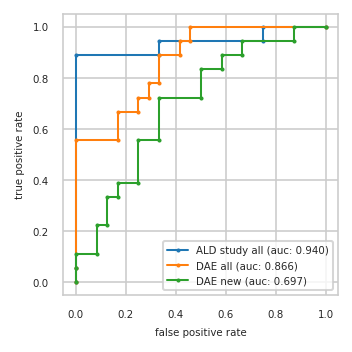

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       DAE all       DAE new      
             fpr   tpr     fpr   tpr     fpr   tpr
0          0.000 0.000   0.000 0.000   0.000 0.000
1          0.000 0.056   0.000 0.056   0.000 0.056
2          0.000 0.889   0.000 0.556   0.000 0.111
3          0.333 0.889   0.167 0.556   0.083 0.111
4          0.333 0.944   0.167 0.667   0.083 0.222
5          0.750 0.944   0.250 0.667   0.125 0.222
6          0.750 1.000   0.250 0.722   0.125 0.333
7          1.000 1.000   0.292 0.722   0.167 0.333
8            NaN   NaN   0.292 0.778   0.167 0.389
9            NaN   NaN   0.333 0.778   0.250 0.389
10           NaN   NaN   0.333 0.889   0.250 0.556
11           NaN   NaN   0.417 0.889   0.333 0.556
12           NaN   NaN   0.417 0.944   0.333 0.722
13           NaN   NaN   0.458 0.944   0.500 0.722
14           NaN   NaN   0.458 1.000   0.500 0.833
15           NaN   NaN   1.000 1.000   0.583 0.833
16           NaN   NaN     NaN   NaN   0.583 0.889
17           NaN   NaN     NaN   NaN   0.667 0.889
18           NaN   NaN     NaN   NaN   0.667 0.944
19           NaN   NaN     NaN   NaN   0.875 0.944
20           NaN   NaN     NaN   NaN   0.875 1.000
21           NaN   NaN     NaN   NaN   1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,DAE all,DAE new
rank,,,
0,P10636-2;P10636-6,P10636-2;P10636-6,Q14894
1,P09417,B4DGQ7;P21860;P21860-4,P00568;Q5T9B7
2,J3KNE3;P68402,J3KSN0;J3KTR4;J3QKK2;J3QQU6;Q8WVN6,H0Y7T8;P49418;P49418-2
3,P61981,P61981,P31321
4,P04075,Q9Y2T3;Q9Y2T3-3,P51688
5,P14174,A0A0B4J1Z1;C9JAB2;Q16629;Q16629-2;Q16629-3;Q16...,A0A0C4DGV4;E9PLX3;O43504;R4GMU8
6,P08294,Q14894,J3KSJ8;Q9UD71;Q9UD71-2
7,Q9Y2T3;Q9Y2T3-3,P04075,Q9NUQ9
8,P00338;P00338-3,P14174,F8WBF9;Q5TH30;Q9UGV2;Q9UGV2-2;Q9UGV2-3


### Precision-Recall plot on test data

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/prec_recall_curve.pdf


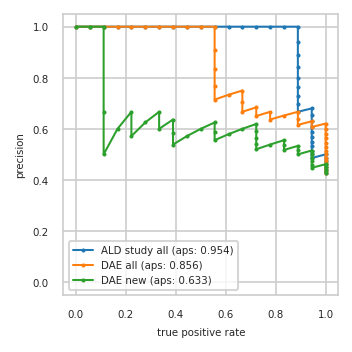

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all         DAE all         DAE new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.462 1.000
4          0.474 1.000     0.474 1.000     0.447 0.944
5          0.486 1.000     0.486 1.000     0.459 0.944
6          0.500 1.000     0.500 1.000     0.472 0.944
7          0.486 0.944     0.514 1.000     0.486 0.944
8          0.500 0.944     0.529 1.000     0.500 0.944
9          0.515 0.944     0.545 1.000     0.515 0.944
10         0.531 0.944     0.562 1.000     0.500 0.889
11         0.548 0.944     0.581 1.000     0.516 0.889
12         0.567 0.944     0.600 1.000     0.533 0.889
13         0.586 0.944     0.621 1.000     0.517 0.833
14         0.607 0.944     0.607 0.944     0.536 0.833
15         0.630 0.944     0.630 0.944     0.556 0.833
16         0.654 0.944     0.615 0.889     0.538 0.778
17         0.680 0.944     0.640 0.889     0.520 0.722
18         0.667 0.889     0.667 0.889     0.542 0.722
19         0.696 0.889     0.652 0.833     0.565 0.722
20         0.727 0.889     0.636 0.778     0.591 0.722
21         0.762 0.889     0.667 0.778     0.619 0.722
22         0.800 0.889     0.650 0.722     0.600 0.667
23         0.842 0.889     0.684 0.722     0.579 0.611
24         0.889 0.889     0.667 0.667     0.556 0.556
25         0.941 0.889     0.706 0.667     0.588 0.556
26         1.000 0.889     0.750 0.667     0.625 0.556
27         1.000 0.833     0.733 0.611     0.600 0.500
28         1.000 0.778     0.714 0.556     0.571 0.444
29         1.000 0.722     0.769 0.556     0.538 0.389
30         1.000 0.667     0.833 0.556     0.583 0.389
31         1.000 0.611     0.909 0.556     0.636 0.389
32         1.000 0.556     1.000 0.556     0.600 0.333
33         1.000 0.500     1.000 0.500     0.667 0.333
34         1.000 0.444     1.000 0.444     0.625 0.278
35         1.000 0.389     1.000 0.389     0.571 0.222
36         1.000 0.333     1.000 0.333     0.667 0.222
37         1.000 0.278     1.000 0.278     0.600 0.167
38         1.000 0.222     1.000 0.222     0.500 0.111
39         1.000 0.167     1.000 0.167     0.667 0.111
40         1.000 0.111     1.000 0.111     1.000 0.111
41         1.000 0.056     1.000 0.056     1.000 0.056
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/prec_recall_curve_train.pdf


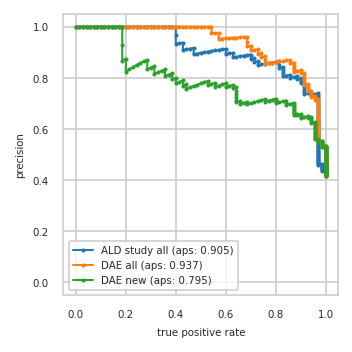

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/auc_roc_curve_train.pdf


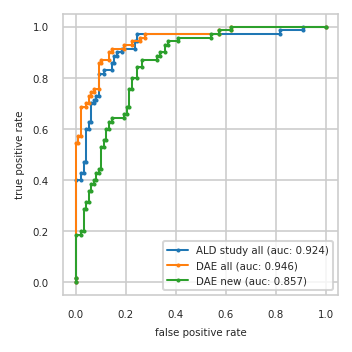

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_DAE all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/results_DAE all.pkl'),
 'results_DAE new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/results_DAE new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/auc_roc_curve_train.pdf')}